# Notebook contents:
### 1. PyTorch implementation of Neural Admixture
### 2. PCA code to initialize P matrix (weight of decoder layer, see paper for details https://www.nature.com/articles/s43588-023-00482-7)
### 3. Plotting neural admixture vs admixture (K=3, 4, 5, 6, 7) for example_dataset (subset of 1000Genomes chr21)
### 4. Benchmarking results (Time comparison plot at the end)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from pandas_plink import read_plink
from tqdm.auto import tqdm
import numpy as np
from scipy.stats import mode
import random

from dask_ml.decomposition import IncrementalPCA as DaskIncrementalPCA
from py_pcha import PCHA
import time

seed=43
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [13]:
def load_data(path, file_type="plink", imputation_type="mean"):
    
    if file_type == "plink":
        print("Loading data...")
        (_, _, G) = read_plink(path)
        
    # ADD MORE FILE TYPES HERE LATER
    
    else:
        raise Exception("Invalid File Type")
    
    print("Normalizing data...")
    G_norm = G.T/2.0
    
    if imputation_type == "zero":
        print("Imputing null with zero...")
        G_norm = np.nan_to_num(G_norm,0.)
        
    elif imputation_type == "mean":
        print("Imputing null with mean...")
        snp_means = np.nanmean(G_norm, axis=0)[None, :]
        G_norm = np.where(np.isnan(G_norm), snp_means, G_norm)
        
    else:
        raise Exception("Invalid Imputation Type")
        
    return G_norm

## Neural Admixture Model

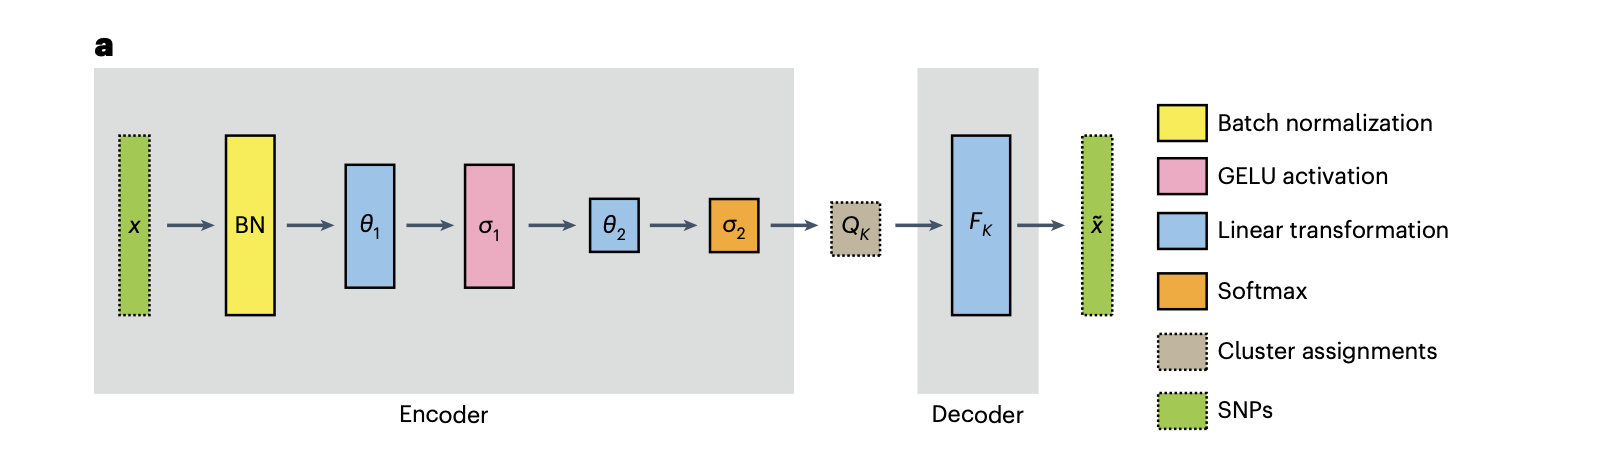

In [8]:
class NeuralAdmixture(nn.Module):
    
    def __init__(self,k: int, num_features: int, hidden_size: int=64):
        super().__init__()
        
        # Store the number of clusters (k), input features, and hidden layer size
        self.k = k
        self.num_features = num_features
        self.hidden_size = hidden_size
        
        # Batch normalization layer for the input features
        self.batch_norm =  nn.BatchNorm1d(self.num_features)
        
        # Encoder network with a linear layer followed by GELU activation
        self.encoder = nn.Sequential(
                nn.Linear(self.num_features, self.hidden_size, bias=True),
                nn.GELU()   
        )
        
        # Hidden layer that maps the encoder output to the admixture fractions (Q)
        self.hidden_layer = nn.Linear(self.hidden_size, self.k, bias=True)
        
        # Softmax activation to ensure admixture fractions are non-negative and sum to 1
        self.softmax = nn.Softmax(dim=1)
        
        # Decoder layer that maps the admixture fractions to the reconstructed input
        self.decoder = nn.Linear(self.k, self.num_features, bias=False)

        
    def forward(self, X: torch.Tensor):
        
        # Apply batch normalization to the input features
        X = self.batch_norm(X)
        
        # Pass the input through the encoder network
        enc = self.encoder(X)
        
        # Pass the encoder output through the hidden layer to get the admixture fractions
        h = self.hidden_layer(enc)
        
        # Apply softmax activation to the admixture fractions
        probs = self.softmax(h)
        
        # Pass the admixture fractions through the decoder to reconstruct the input
        dec = self.decoder(probs)
        
        # Clamp the reconstructed input to be between 0 and 1 (valid allele frequencies)
        rec = torch.clamp(dec, 0, 1)

        return rec, probs

## Initialize P matrix values using the PCA of Genotype Matrix

In [12]:
def initialize_p(data, k, plot_pca=True):
    
    # Perform Incremental PCA on the input data using Dask
    PCA = DaskIncrementalPCA(n_components=2, random_state=42, batch_size=400)
    PCA.fit(data)
    
    # Transform the input data to the 2-dimensional PCA space
    X_proj = PCA.transform(data).compute()
    
    if plot_pca == True:
        plt.figure(figsize=(12, 6))
        plt.scatter(X_proj[:, 0], X_proj[:, 1], s=.9, c='black')
        plt.xticks([])
        plt.yticks([])
        plt.title('Training data projected onto first two components with Dask IncrementalPCA for K='+str(k))
        plt.show()
    
    # Perform archetypal analysis on the projected data to find k archetypes
    archs = np.array(PCHA(X_proj.T, noc=k, delta=0.001)[0].T)
    
    # Transform the archetypes back to the original feature space using the inverse PCA transform
    P_init = torch.as_tensor(PCA.inverse_transform(archs).compute(), dtype=torch.float32).T.to(device)
    
    return P_init

## Code to plot admixture results

In [11]:
def plot_1000Genomes(matrix_, method):
    fig = plt.figure()
    fig.set_size_inches((10, 8))

    plotind = 1

    ax = fig.add_subplot(3, 1, plotind)

    data = pd.DataFrame(matrix_)
    cols = list(data.columns)
    data["sample"] = samples
    data["pop"] = pops
    data = data.sort_values(["pop"]+cols)
    data.plot.bar(stacked=True, ax=ax, width=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Only plot label for first sample in each pop
    xticklabels = []
    currpop = ""
    for i in range(data.shape[0]):
        if data["pop"].values[i] == currpop:
            xticklabels.append("")
        else:
            xticklabels.append(data["pop"].values[i])
            currpop = data["pop"].values[i]
    ax.set_xticklabels(xticklabels)
    ax.set_title(f"{method} for K={matrix_.shape[1]}")

    plotind += 1
    fig.tight_layout()
    

## Autoencoder training loop

In [10]:
def run_neural_admixture(path,k,max_epochs=500, learning_rate=1e-05, l2_penalty=0.0005, hidden_size=64, tol=1e-06):
    
    data = load_data(path)
    
    print(f"\n\nNeural Admixture for K = {k}, sample = {data.shape[0]}, SNPs = {data.shape[1]}")

    print("Initializing P...")
    P_init = initialize_p(data,k,False)
    
    print(f"Initializing Model...")
    model = NeuralAdmixture(k, data.shape[1], hidden_size=hidden_size).to(device)
    loss_f = nn.BCELoss(reduction='mean')
    optimizer=optim.Adam(model.parameters(), lr=learning_rate)

    X = torch.tensor(data.compute()).to(device)

    tr_losses = []

    model.decoder.weight = torch.nn.Parameter(P_init)
    model.train()
    
    print("Fitting model...")

    for ep in tqdm(range(max_epochs)):

        optimizer.zero_grad(set_to_none=True)

        rec, probs = model(X)
        loss = loss_f(rec, X)

        enc_params = torch.cat([x.view(-1) for x in model.encoder.parameters()])
        hidden_params = torch.cat([x.view(-1) for x in model.hidden_layer.parameters()])

        overall_encoder_norm = torch.norm(enc_params, 2)+torch.norm(hidden_params, 2)

        loss += l2_penalty*overall_encoder_norm**2

        loss.backward()
        optimizer.step()
        mean_loss = loss/X.shape[0]
        tr_losses.append(mean_loss)

        tr_diff = tr_losses[-2]-tr_losses[-1] if len(tr_losses) > 1 else 'NaN'

        print(f'EPOCH {ep+1}: mean training loss: {mean_loss}, diff: {tr_diff}')

        if ep > 15 and tol > 0 and tr_diff < tol:
            print(f'Convergence criteria met. Stopping fit after {ep+1} epochs...')
            break
    
    if (ep+1)==max_epochs:
        print(f'Max epochs reached. Stopping fit...')
        
    return probs.cpu().detach().numpy()


## Code to run admixture software using command line
## Make sure it is installed locally!

In [5]:
def run_admixture(path,k):
    print(f"Running ADMIXTURE for K={k}...")
    # Construct the command to run
    cmd = f"admixture --cv {path}.bed {k}"
    
    # Execute the command and capture the output
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    # Decode and print the output to console
    print(stdout.decode())
    if (stderr):
        print(stderr.decode())
    
    files = [f"{PREFIX}.{k}.P", f"{PREFIX}.{k}.Q"]
    out_files = [f"admixture.{k}.P", f"admixture.{k}.Q"]
    
    # Move files to output folder
    for old,new in zip(files,out_files):
        if os.path.exists(old):
            shutil.move(old, os.path.join(output_dir, new))

## Dataset
example_data - Subset of 1000 Genome Dataset for chr21

In [8]:
PREFIX = "example_data" 
data_dir = "example_data/"
output_dir = "outputs" 
os.makedirs(output_dir, exist_ok=True)

In [9]:
sampleinfo = pd.read_csv(f"{data_dir}{PREFIX}.tsv", sep="\t")
sample_to_pop = dict(zip(list(sampleinfo["Sample name"]), list(sampleinfo["Population code"])))
samples = [line.split()[0] for line in open(f"{data_dir}{PREFIX}.fam", "r").readlines()]
pops = [sample_to_pop.get(item, "NA") for item in samples]

In [10]:
gt = np.loadtxt(f"{data_dir}GT.Q")

## Neural ADMIXTURE for K=3

Loading data...


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 17.58it/s]

Normalizing data...
Imputing null with mean...


Neural Admixture for K = 3, sample = 462, SNPs = 26499
Initializing P...


Initializing Model...
Fitting model...


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1: mean training loss: 0.0005404582479968667, diff: NaN
EPOCH 2: mean training loss: 0.0005361794028431177, diff: 4.278845153748989e-06
EPOCH 3: mean training loss: 0.0005322529468685389, diff: 3.926455974578857e-06
EPOCH 4: mean training loss: 0.000528666831087321, diff: 3.5861157812178135e-06
EPOCH 5: mean training loss: 0.0005254066782072186, diff: 3.260152880102396e-06
EPOCH 6: mean training loss: 0.0005224950728006661, diff: 2.911605406552553e-06
EPOCH 7: mean training loss: 0.0005199023289605975, diff: 2.5927438400685787e-06
EPOCH 8: mean training loss: 0.0005175875849090517, diff: 2.3147440515458584e-06
EPOCH 9: mean training loss: 0.0005155651015229523, diff: 2.0224833860993385e-06
EPOCH 10: mean training loss: 0.000513784063514322, diff: 1.7810380086302757e-06
EPOCH 11: mean training loss: 0.0005122670554555953, diff: 1.5170080587267876e-06
EPOCH 12: mean training loss: 0.0005110488855279982, diff: 1.218169927597046e-06
EPOCH 13: mean training loss: 0.0005101038259454072

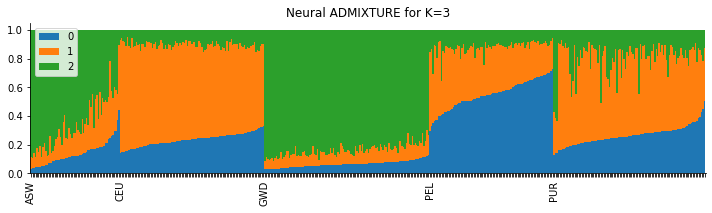

In [11]:
start_time = time.time()
k=3
probs = run_neural_admixture(data_dir+PREFIX,k)
plot_1000Genomes(probs,"Neural ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

## ADMIXTURE for K=3

Running ADMIXTURE for K=3...
****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 462x26499
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 0.624	Loglikelihood: -6.08554e+06	(delta): 1.36179e+07
2 (EM) 	Elapsed:

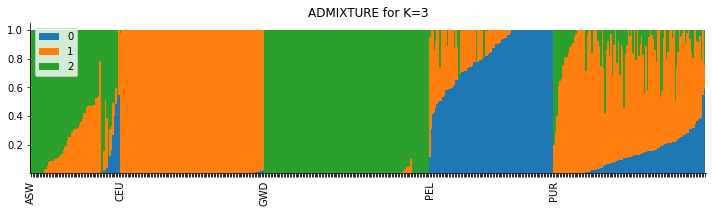

In [12]:
start_time = time.time()
k=3
run_admixture(data_dir+PREFIX,k)
probs = np.loadtxt(f"{output_dir}/admixture.{k}.Q")
plot_1000Genomes(probs,"ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

## Neural ADMIXTURE for K=4

Loading data...


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 24.03it/s]

Normalizing data...
Imputing null with mean...


Neural Admixture for K = 4, sample = 462, SNPs = 26499
Initializing P...


Initializing Model...
Fitting model...


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1: mean training loss: 0.0005483260028995574, diff: NaN
EPOCH 2: mean training loss: 0.0005437987274490297, diff: 4.527275450527668e-06
EPOCH 3: mean training loss: 0.0005399746587499976, diff: 3.824068699032068e-06
EPOCH 4: mean training loss: 0.0005364438402466476, diff: 3.5308185033500195e-06
EPOCH 5: mean training loss: 0.0005334141314961016, diff: 3.0297087505459785e-06
EPOCH 6: mean training loss: 0.0005306745297275484, diff: 2.739601768553257e-06
EPOCH 7: mean training loss: 0.0005281842895783484, diff: 2.4902401491999626e-06
EPOCH 8: mean training loss: 0.000525885378010571, diff: 2.2989115677773952e-06
EPOCH 9: mean training loss: 0.0005238262237980962, diff: 2.059154212474823e-06
EPOCH 10: mean training loss: 0.0005220040329732001, diff: 1.8221908248960972e-06
EPOCH 11: mean training loss: 0.0005204107728786767, diff: 1.5932600945234299e-06
EPOCH 12: mean training loss: 0.0005189524963498116, diff: 1.458276528865099e-06
EPOCH 13: mean training loss: 0.000517673441208899

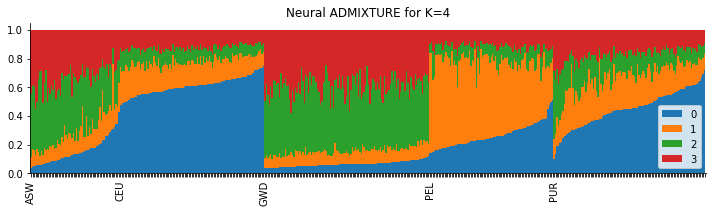

In [13]:
start_time = time.time()
k=4
probs = run_neural_admixture(data_dir+PREFIX,k)
plot_1000Genomes(probs,"Neural ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

## ADMIXTURE for K=4

Running ADMIXTURE for K=4...
****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 462x26499
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 0.824	Loglikelihood: -6.13964e+06	(delta): 1.28846e+07
2 (EM) 	Elapsed:

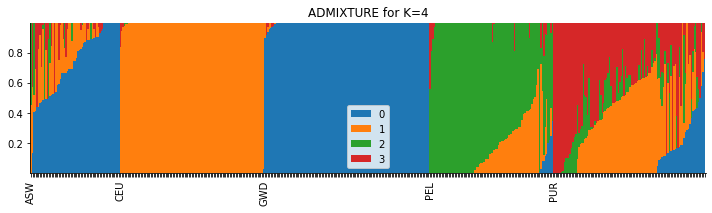

In [14]:
start_time = time.time()
k=4
run_admixture(data_dir+PREFIX,k)
probs = np.loadtxt(f"{output_dir}/admixture.{k}.Q")
plot_1000Genomes(probs,"ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

## Neural ADMIXTURE for K=5

Loading data...


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 23.36it/s]

Normalizing data...
Imputing null with mean...


Neural Admixture for K = 5, sample = 462, SNPs = 26499
Initializing P...


Initializing Model...
Fitting model...


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1: mean training loss: 0.0005557106342166662, diff: NaN
EPOCH 2: mean training loss: 0.0005507658934220672, diff: 4.944740794599056e-06
EPOCH 3: mean training loss: 0.0005465542781166732, diff: 4.211615305393934e-06
EPOCH 4: mean training loss: 0.0005425136187113822, diff: 4.0406594052910805e-06
EPOCH 5: mean training loss: 0.000539046770427376, diff: 3.4668482840061188e-06
EPOCH 6: mean training loss: 0.0005358477937988937, diff: 3.1989766284823418e-06
EPOCH 7: mean training loss: 0.0005330544663593173, diff: 2.7933274395763874e-06
EPOCH 8: mean training loss: 0.0005304685910232365, diff: 2.5858753360807896e-06
EPOCH 9: mean training loss: 0.0005282485508359969, diff: 2.220040187239647e-06
EPOCH 10: mean training loss: 0.0005263292696326971, diff: 1.919281203299761e-06
EPOCH 11: mean training loss: 0.0005246426444500685, diff: 1.6866251826286316e-06
EPOCH 12: mean training loss: 0.0005232060211710632, diff: 1.436623279005289e-06
EPOCH 13: mean training loss: 0.000521983252838254

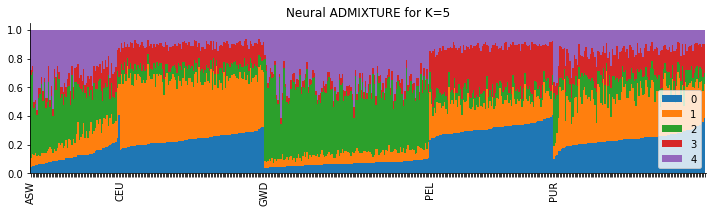

In [15]:
start_time = time.time()
k=5
probs = run_neural_admixture(data_dir+PREFIX,k)
print("RMSE: ",np.sqrt(np.mean((gt - probs)**2)))
plot_1000Genomes(probs,"Neural ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

## ADMIXTURE for K=5

Running ADMIXTURE for K=5...
****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 462x26499
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 1.095	Loglikelihood: -6.15376e+06	(delta): 1.24649e+07
2 (EM) 	Elapsed:

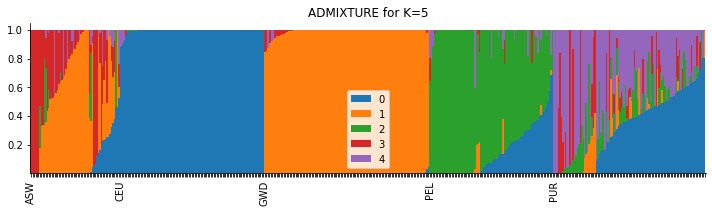

In [16]:
start_time = time.time()
k=5
run_admixture(data_dir+PREFIX,k)
probs = np.loadtxt(f"{output_dir}/admixture.{k}.Q")
print("RMSE: ",np.sqrt(np.mean((gt - probs)**2)))
plot_1000Genomes(probs,"ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

## Neural ADMIXTURE for K=6

Loading data...


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 14.21it/s]


Normalizing data...
Imputing null with mean...


Neural Admixture for K = 6, sample = 462, SNPs = 26499
Initializing P...
Initializing Model...
Fitting model...


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1: mean training loss: 0.0005586257902905345, diff: NaN
EPOCH 2: mean training loss: 0.0005525159649550915, diff: 6.10982533544302e-06
EPOCH 3: mean training loss: 0.0005480198306031525, diff: 4.496134351938963e-06
EPOCH 4: mean training loss: 0.0005447494913823903, diff: 3.270339220762253e-06
EPOCH 5: mean training loss: 0.000542017980478704, diff: 2.731510903686285e-06
EPOCH 6: mean training loss: 0.0005396285559982061, diff: 2.389424480497837e-06
EPOCH 7: mean training loss: 0.0005373209132812917, diff: 2.3076427169144154e-06
EPOCH 8: mean training loss: 0.0005352639127522707, diff: 2.0570005290210247e-06
EPOCH 9: mean training loss: 0.0005333136068657041, diff: 1.950305886566639e-06
EPOCH 10: mean training loss: 0.0005315286689437926, diff: 1.784937921911478e-06
EPOCH 11: mean training loss: 0.0005298376781865954, diff: 1.6909907571971416e-06
EPOCH 12: mean training loss: 0.0005282459314912558, diff: 1.5917466953396797e-06
EPOCH 13: mean training loss: 0.0005267886444926262, 

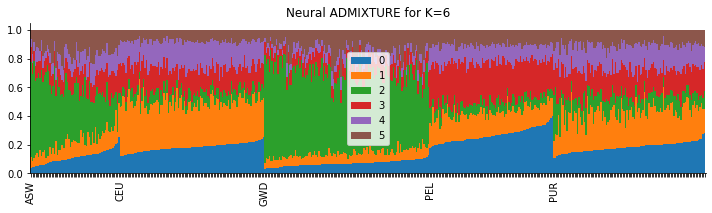

In [11]:
start_time = time.time()
k=6
probs = run_neural_admixture(data_dir+PREFIX,k)
plot_1000Genomes(probs,"Neural ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

## ADMIXTURE for K=6

Running ADMIXTURE for K=6...
****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 462x26499
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 1.328	Loglikelihood: -6.16161e+06	(delta): 1.22186e+07
2 (EM) 	Elapsed:

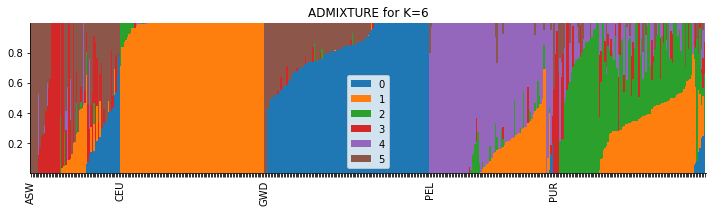

In [15]:
start_time = time.time()
k=6
run_admixture(data_dir+PREFIX,k)
probs = np.loadtxt(f"{output_dir}/admixture.{k}.Q")
plot_1000Genomes(probs,"ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

## Neural ADMIXTURE for K=7

Loading data...


Mapping files: 100%|██████████| 3/3 [00:00<00:00, 20.24it/s]

Normalizing data...
Imputing null with mean...


Neural Admixture for K = 7, sample = 462, SNPs = 26499
Initializing P...


Initializing Model...
Fitting model...


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1: mean training loss: 0.0005524771404452622, diff: NaN
EPOCH 2: mean training loss: 0.0005488559254445136, diff: 3.6212150007486343e-06
EPOCH 3: mean training loss: 0.0005457328516058624, diff: 3.1230738386511803e-06
EPOCH 4: mean training loss: 0.0005428588483482599, diff: 2.8740032576024532e-06
EPOCH 5: mean training loss: 0.0005402126116678119, diff: 2.6462366804480553e-06
EPOCH 6: mean training loss: 0.0005378457135520875, diff: 2.366898115724325e-06
EPOCH 7: mean training loss: 0.0005356331821531057, diff: 2.2125313989818096e-06
EPOCH 8: mean training loss: 0.000533715239726007, diff: 1.917942427098751e-06
EPOCH 9: mean training loss: 0.0005319121410138905, diff: 1.8030987121164799e-06
EPOCH 10: mean training loss: 0.0005303911748342216, diff: 1.5209661796689034e-06
EPOCH 11: mean training loss: 0.0005289983237162232, diff: 1.3928511179983616e-06
EPOCH 12: mean training loss: 0.0005278096068650484, diff: 1.1887168511748314e-06
EPOCH 13: mean training loss: 0.000527856929693

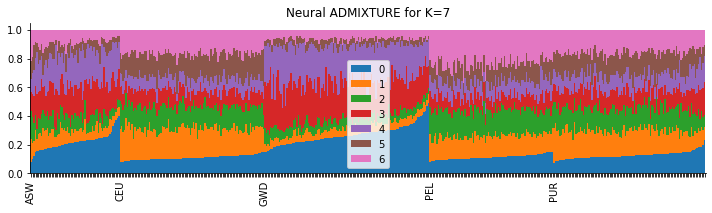

In [16]:
start_time = time.time()
k=7
probs = run_neural_admixture(data_dir+PREFIX,k)
plot_1000Genomes(probs,"Neural ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

## ADMIXTURE for K=7

Running ADMIXTURE for K=7...
****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 462x26499
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 1.925	Loglikelihood: -6.16128e+06	(delta): 1.20337e+07
2 (EM) 	Elapsed:

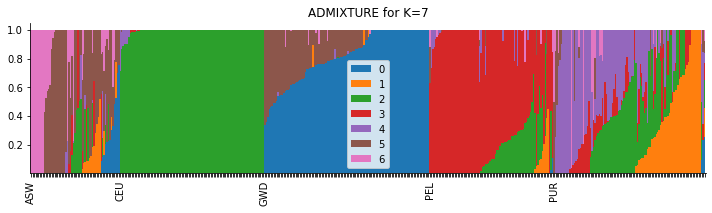

In [17]:
start_time = time.time()
k=7
run_admixture(data_dir+PREFIX,k)
probs = np.loadtxt(f"{output_dir}/admixture.{k}.Q")
plot_1000Genomes(probs,"ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

## CHR 22

In [25]:
PREFIX = "gen0_chr22_valid" 
data_dir = "data/"
output_dir = "data/outputs" 
os.makedirs(output_dir, exist_ok=True)

In [26]:
gt = np.loadtxt(f"{data_dir}GT_valid.Q")

In [27]:
gt

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [28]:
start_time = time.time()
k=7
probs = run_neural_admixture(data_dir+PREFIX,k)
print("RMSE: ",np.sqrt(np.mean((gt - probs)**2)))
#plot_1000Genomes(probs,"Neural ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

Loading data...


Mapping files: 100%|██████████| 3/3 [00:14<00:00,  4.86s/it]


Normalizing data...
Imputing null with mean...


Neural Admixture for K = 7, sample = 444, SNPs = 317408
Initializing P...
Initializing Model...
Fitting model...


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1: mean training loss: 0.0004248419718351215, diff: NaN
EPOCH 2: mean training loss: 0.0004052429285366088, diff: 1.9599043298512697e-05
EPOCH 3: mean training loss: 0.0003982371126767248, diff: 7.005815859884024e-06
EPOCH 4: mean training loss: 0.0003952951810788363, diff: 2.9419315978884697e-06
EPOCH 5: mean training loss: 0.00039477014797739685, diff: 5.25033101439476e-07
EPOCH 6: mean training loss: 0.00039426260627806187, diff: 5.075416993349791e-07
EPOCH 7: mean training loss: 0.0003937077708542347, diff: 5.548354238271713e-07
EPOCH 8: mean training loss: 0.00039324574754573405, diff: 4.6202330850064754e-07
EPOCH 9: mean training loss: 0.00039289184496738017, diff: 3.5390257835388184e-07
EPOCH 10: mean training loss: 0.000392624904634431, diff: 2.6694033294916153e-07
EPOCH 11: mean training loss: 0.00039250211557373405, diff: 1.227890606969595e-07
EPOCH 12: mean training loss: 0.0003924736229237169, diff: 2.8492650017142296e-08
EPOCH 13: mean training loss: 0.00039251754060

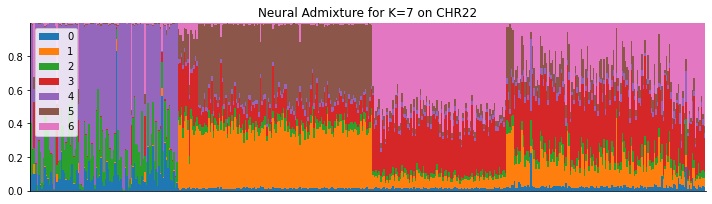

In [32]:
fig = plt.figure()
fig.set_size_inches((10, 8))

plotind = 1

ax = fig.add_subplot(3, 1, plotind)

plot_data = pd.DataFrame(probs)
cols = list(plot_data.columns)
#plot_data = plot_data.sort_values(cols)
plot_data.plot.bar(stacked=True, ax=ax, width=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.set_title(f"Neural Admixture for K={probs.shape[1]} on CHR22")

plotind += 1
fig.tight_layout()

In [33]:
start_time = time.time()
k=7
run_admixture(data_dir+PREFIX,k)
probs = np.loadtxt(f"{output_dir}/admixture.{k}.Q")
print("RMSE: ",np.sqrt(np.mean((gt - probs)**2)))
#plot_1000Genomes(probs,"ADMIXTURE")
print("--- Time Take: %s seconds ---" % (time.time() - start_time))

Running ADMIXTURE for K=7...
****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 444x317408
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 17.78	Loglikelihood: -5.06696e+07	(delta): 1.58292e+08
2 (EM) 	Elapsed

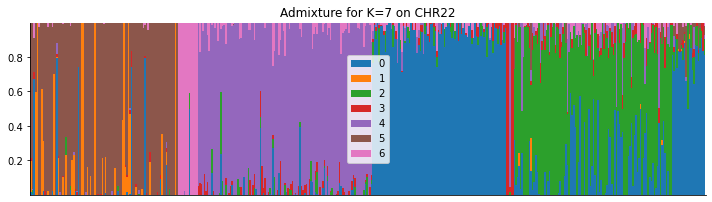

In [34]:
fig = plt.figure()
fig.set_size_inches((10, 8))

plotind = 1

ax = fig.add_subplot(3, 1, plotind)

plot_data = pd.DataFrame(probs)
cols = list(plot_data.columns)
#plot_data = plot_data.sort_values(cols)
plot_data.plot.bar(stacked=True, ax=ax, width=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.set_title(f"Admixture for K={probs.shape[1]} on CHR22")

plotind += 1
fig.tight_layout()

## Overall Results

| Dataset        | K | Model          | RMSE ($Q$, $Q_{GT}$) | Runtime CPU | Runtime GPU|
|:--------------:|:-:|:--------------:|:--------------------:|:-----------:|:----------:|
|**1000 Genomes**| 3 |ADMIXTURE       |  -                   |52.724s      |-           |
|                |   |Neural Admixture|  -                   |73.509s      |9.956s      |
|                | 4 |ADMIXTURE       |  -                   |168.188s     |-           |
|                |   |Neural Admixture|  -                   |75.883s      |8.864s      |
|                | 5 |ADMIXTURE       |  0.5708              |291.030s     |-           |
|                |   |Neural Admixture|  0.3836              |75.608s      |9.422s      |
|                | 6 |ADMIXTURE       |  -                   |344.221s     |-           |
|                |   |Neural Admixture|  -                   |113.506s     |10.491s     |
|                | 7 |ADMIXTURE       |  -                   |1179.152s    |-           |
|                |   |Neural Admixture|  -                   |255.439s     |10.564s     |
|  **CHR22 Sim** | 7 |ADMIXTURE       |  0.5016              |3235.979s    |-           |
|                |   |Neural Admixture|  0.3925              |291.952s     |24.570s     |


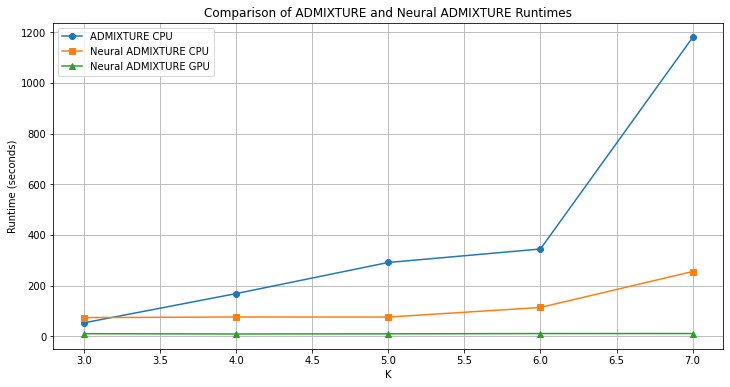

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# The data as read from the image
data = {
    "K": [3, 4, 5, 6, 7],
    "ADMIXTURE_CPU": [52.724, 168.188, 291.030, 344.221, 1179.152],
    "Neural_Admixture_CPU": [73.509, 75.883, 75.608, 113.506, 255.439],
    "Neural_Admixture_GPU": [9.956, 8.864, 9.422, 10.491, 10.564]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(12, 6))

# ADMIXTURE CPU
plt.plot(df["K"], df["ADMIXTURE_CPU"], label="ADMIXTURE CPU", marker='o')

# Neural ADMIXTURE CPU
plt.plot(df["K"], df["Neural_Admixture_CPU"], label="Neural ADMIXTURE CPU", marker='s')

# Neural ADMIXTURE GPU
plt.plot(df["K"], df["Neural_Admixture_GPU"], label="Neural ADMIXTURE GPU", marker='^')

# Labeling
plt.xlabel('K')
plt.ylabel('Runtime (seconds)')
plt.title('Comparison of ADMIXTURE and Neural ADMIXTURE Runtimes')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


In [20]:
df

,K,ADMIXTURE_CPU,Neural_Admixture_CPU,Neural_Admixture_GPU
0,3,52.724,73.509,9.956
1,4,168.188,75.883,8.864
2,5,291.030,75.608,9.422
3,6,344.221,113.506,10.491
4,7,1179.152,255.439,10.564
